# Congruence via Entity Vector Similarity

In this notebook, we calculate the cosine similarity measure between vectors of each entity candidate. The vectors will be retrieved from Wikipedia2vec's pre-trained API, which creates vectors for the entire Wikipedia page. Comparing two vectors in this way thus lets us make a statement about similar pages and update our likelihood scores based on that.

#### (i) Via Weights

In Phase 4, we calculate congruence between candidates in pools for mentions in the same sentence. We then update the likelihood values from Phase 3 using congruence as a form of "weights". This should adjust our pool without eliminating the prior knowledge we have of the calculated similarity. In this notebook, we import prior knowledge generated from Anchor Link statistics and weight those with our numerical calculations from congruence.

### Import Packages

In [1]:
import os
import time
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.pairwise import cosine_similarity

# Progress bar
from tqdm import tqdm

In [54]:
# Base path to input
preds_path = '../../predictions/'

# Load data
predictions = pd.read_csv(os.path.join(preds_path, "anchortext_frequency.csv"), delimiter=",")
predictions.head(5)

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_likelihoods
0,B,EU,NaN,NaN,NaN,0,0,"['EU', 'German', 'British']",eu,"[9317, 9239, 21347120, 9477, 1882861, 3261189,...","[458, 46, 211593, 1396, 363404, 3327447, 40537...","['European_Union', 'Europe', 'Eu,_Seine-Mariti...","[0.9227799, 0.024651, 0.020196, 0.005346, 0.00..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"['EU', 'German', 'British']",german,"[11867, 11884, 152735, 21212, 12674, 290327, 1...","[183, 188, 42884, 7318, 43287, 141817, 181287,...","['Germany', 'German_language', 'Germans', 'Naz...","[0.4191423, 0.2892399, 0.14703, 0.0382718, 0.0..."
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"['EU', 'German', 'British']",british,"[31717, 19097669, 13530298, 4721, 158019, 1522...","[145, 842438, 23666, 8680, 161885, 174193, 354...","['United_Kingdom', 'British_people', 'Great_Br...","[0.610078, 0.1146438, 0.0681775, 0.0366451, 0...."
3,B,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",peter blackburn,"[56783206, 9643132, 56873217]","[2073954, 7172840, 26634508]","['Peter_Blackburn_(badminton)', 'Peter_Blackbu...","[0.5, 0.3, 0.2]"
4,I,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",peter blackburn,"[56783206, 9643132, 56873217]","[2073954, 7172840, 26634508]","['Peter_Blackburn_(badminton)', 'Peter_Blackbu...","[0.5, 0.3, 0.2]"


### Parse Saved Candidate Pool

Candidate pools when exported are typically stored as the string of a list. The below function parses the string back into a list with proper formatted values.

In [55]:
# Demonstrate that list is string
type(predictions['candidate_pool_page_ids'][0])

str

In [60]:
# Function to parse list as string
def parse_list_string(list_string, value_type=int):
    
    parsed_list = []
    
    # If candidate pool is empty
    if list_string == "[]" or isinstance(list_string, float):
        pass
    # Else parse
    else:
        # Parses lists of titles as strings
        if value_type==str:
            # Eliminate bracket and parenthesis on either side, split by comma pattern
            parsed_list = re.split("', '|\", \"|', \"|\", \'", list_string[2:-2])

        # Parses lists of IDs as ints
        elif value_type==int:
            # Eliminate brackets and convert each number from string to int
            parsed_list = list(map(int, list_string[1:-1].split(', ')))
        elif value_type==float:
            # Eliminate brackets and convert each number from string to int
            parsed_list = list(map(float, list_string[1:-1].split(', ')))
            
        
    return parsed_list


In [57]:
# Manually test function
# 0 is the hard one. See how some value is stored with '' and some with "". Unsure why.
parse_list_string(predictions['candidate_pool_titles'][0], value_type=str)

['European_Union',
 'Europe',
 'Eu,_Seine-Maritime',
 'Europium',
 'Citizenship_of_the_European_Union',
 'United_Left_(Galicia)',
 'EU_(group)',
 'European_Union_law',
 'Eu_station',
 'Entropy']

In [58]:
# Manually test function
# 0 is the hard one. See how some value is stored with '' and some with "". Unsure why.
parse_list_string(predictions['candidate_pool_page_ids'][0], value_type=int)

[9317,
 9239,
 21347120,
 9477,
 1882861,
 3261189,
 14024977,
 276436,
 27532324,
 9891]

In [9]:
# Manually test function
parse_list_string(predictions['candidate_pool_page_ids'][13], value_type=int)

[]

In [63]:
# Manually test function
parse_list_string(predictions['candidate_pool_likelihoods'][0], value_type=float)

[0.9227799,
 0.024651,
 0.020196,
 0.005346,
 0.002079,
 0.001782,
 0.001485,
 0.001188,
 0.001188,
 0.000891]

In [64]:
%%time

### Apply defined function to entire dataframe for all candidate pool columns

column = 'congruent_mentions'
print("Before", predictions[column][3])
parsed_candidate_pool = predictions[column].apply(parse_list_string, value_type=str)
predictions[column] = parsed_candidate_pool
print("After", predictions[column][3])

column = 'candidate_pool_page_ids'
print("Before", predictions[column][3])
parsed_candidate_pool = predictions[column].apply(parse_list_string, value_type=int)
predictions[column] = parsed_candidate_pool
print("After", predictions[column][3])


column = 'candidate_pool_item_ids'
print("Before", predictions[column][3])
parsed_candidate_pool = predictions[column].apply(parse_list_string, value_type=int)
predictions[column] = parsed_candidate_pool
print("After", predictions[column][3])


column = 'candidate_pool_titles'
print("Before", predictions[column][3])
parsed_candidate_pool = predictions[column].apply(parse_list_string, value_type=str)
predictions[column] = parsed_candidate_pool
print("After", predictions[column][3])

column = 'candidate_pool_likelihoods'
print("Before", predictions[column][3])
parsed_candidate_pool = predictions[column].apply(parse_list_string, value_type=float)
predictions[column] = parsed_candidate_pool
print("After", predictions[column][3])

Before ['Peter Blackburn', 'BRUSSELS', 'European Commission', 'German', 'British']
After ['Peter Blackburn', 'BRUSSELS', 'European Commission', 'German', 'British']
Before [56783206, 9643132, 56873217]
After [56783206, 9643132, 56873217]
Before [2073954, 7172840, 26634508]
After [2073954, 7172840, 26634508]
Before ['Peter_Blackburn_(badminton)', 'Peter_Blackburn_(bishop)', 'Peter_Blackburn_(MP)']
After ['Peter_Blackburn_(badminton)', 'Peter_Blackburn_(bishop)', 'Peter_Blackburn_(MP)']
Before [0.5, 0.3, 0.2]
After [0.5, 0.3, 0.2]
CPU times: user 726 ms, sys: 270 ms, total: 996 ms
Wall time: 1.09 s


## Retrieve Entity Vectors from Wikipedia2Vec

For provided wikipedia pages, we retrieve a representative entity vector from Wikipedia2vec. This involves passing the normalized title into their get_entity_vector() function.

In [11]:
# Package
from wikipedia2vec import Wikipedia2Vec

In [12]:
%%time
# Load unzipped pkl file with word embeddings
w2v = Wikipedia2Vec.load("../../embeddings/enwiki_20180420_100d.pkl")

CPU times: user 111 ms, sys: 145 ms, total: 256 ms
Wall time: 333 ms


### Assess Coverage of Candidate Pools in Wikipedia2vec

We need to measure what percent of candidates in our candidate pools successfully return a vector from Wikipedia2vec. This should conceivably be 100% given we're passing known Wikipedia pages into this package trained over Wikipedia pages, but there may be some drop-off due to different creation dates.

In [65]:
# Define text normalization function
def normalize_text(text):
    """
    We define normalized as:
    - strip whitespace
    - Spaces, not underlines
    """
    return str(text).strip().replace("_", " ")

In [66]:
# Iterate over candidate pool titles to see what can be returned

found_entity = 0
searched_entity = 0

for i in tqdm(range(len(predictions))):
    
    # Retrieve candidate pool
    candidate_pool = predictions['candidate_pool_titles'][i]
    
    # Query for each candidate
    for candidate in candidate_pool:
        # Normalize candidate title to form necessary to input into Wikipedia2vec
        candidate = normalize_text(candidate)
        
        # Query Wikipedia2vec get_entity_vector()
        try:
            entity_vector = w2v.get_entity_vector(candidate)
        except KeyError:
            entity_vector = None
        
        # Check if result
        if entity_vector is not None:
            found_entity += 1
        
        # Increment count
        searched_entity += 1

print(f"Wikipedia2vec returned an entity vector for {round(found_entity/searched_entity*100,3)}% of {searched_entity:,} searches")

100%|██████████| 29312/29312 [00:02<00:00, 10249.32it/s]

Wikipedia2vec returned an entity vector for 93.614% of 155,553 searches


## Calculate Congruence Metric between Congruent Entities

First, let's get a sense for what the upper bound of congruent calculations might be.

In [15]:
# What is the maximum number of congruent entities in a single sentence
max(predictions['congruent_mentions'].apply(len))

194

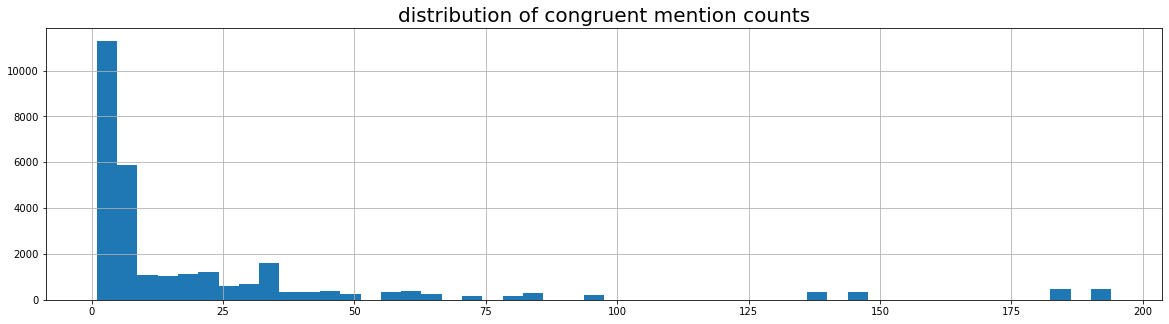

In [16]:
# What is the distribution of congruent mention counts
plt.figure(figsize=(20,5))
predictions['congruent_mentions'].apply(len).hist(bins=50)
plt.title("distribution of congruent mention counts", size=20)
plt.show()

### Capturing Current Design Thinking

In order to allow this to become recursive for N many tables, you will need to capture a congruence table for every candidate pool to every other candidate pool in a two-level dictionary so you can retrieve values using `matrix[3][1]`. This would entail duplication except to save that, we sort by value so you always search [small][large]. Saves us computation and storage. To see a sequential example of our logic, scroll to the end of this notebook. Below is our function-based implementation of our pipeline.

In [304]:
# Define testing sentence_id
sentence_id = 90
sentence_predictions = predictions[predictions['sentence_id'] == sentence_id].reset_index(drop=True)
sentence_predictions

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_likelihoods
0,B,Iran,http://en.wikipedia.org/wiki/Iran,14653.0,Iran,90,11,"[Iran, Turkey, Iraq, Kurdish]",iran,"[14653, 272865, 338883, 8294810, 46823116, 126...","[794, 184602, 207991, 1465546, 932162, 1042614...","[Iran, Iran_national_football_team, Pahlavi_dy...","[0.9790373, 0.0079465, 0.0016392, 0.0005319, 0..."
1,B,Turkey,NaN,NaN,NaN,90,11,"[Iran, Turkey, Iraq, Kurdish]",turkey,"[11125639, 743577, 72821, 24513964, 297071, 22...","[43, 483856, 43794, 4200953, 26844, 12560, 848...","[Turkey, Turkey_national_football_team, Turkey...","[0.9168911, 0.0269033, 0.0082007, 0.0038923, 0..."
2,B,Iraq,http://en.wikipedia.org/wiki/Iraq,7515928.0,Iraq,90,11,"[Iran, Turkey, Iraq, Kurdish]",iraq,"[7515928, 1039652, 5043324, 26215470, 2900620,...","[796, 186243, 545449, 3108185, 149805, 107802,...","[Iraq, Iraq_national_football_team, Iraq_War, ...","[0.8794007, 0.0341074, 0.0292135, 0.0119351, 0..."
3,B,Kurdish,http://en.wikipedia.org/wiki/Kurdish_people,17068.0,Kurdish people,90,11,"[Iran, Turkey, Iraq, Kurdish]",kurdish,"[17068, 40316, 80777, 3821855, 4314285, 354232...","[12223, 36368, 41470, 1792998, 1117020, 121801...","[Kurds, Kurdish_languages, Kurdistan, Kurds_in...","[0.565625, 0.3114583, 0.0159722, 0.0142361, 0...."


In [305]:
print(sentence_predictions['congruent_mentions'][0])

['Iran', 'Turkey', 'Iraq', 'Kurdish']


### Define Functions to Create Modular Congruent Pipeline

In [19]:
# Generate candidate lists of vectors
def get_candidate_pool_vectors(candidate_pool_titles, verbose=False):
    """
    Function to return entity vectors from Wikipedia2Vec
    Takes as input a list of page titles, representing the candidate pool
    Normalizes each page title to match necessary input format
    Returns entity vector or empty vector if no match
    """
    # Track failed vector queries
    no_vector_count = 0
    candidate_pool_vectors = []
    for candidate in candidate_pool_titles:
        candidate = normalize_text(candidate)
        if verbose: print(candidate)
        try:
            candidate_vectors = w2v.get_entity_vector(candidate)
        except KeyError:
            # Keep empty vector representation to maintain index locations
            candidate_vectors = np.zeros(100)
            no_vector_count += 1
        candidate_pool_vectors.append(candidate_vectors)
    
    # Handle case where candidate pool is empty from Phase 3
    # Add arbitrarily chosen 3 arrays of zeros
    if len(candidate_pool_titles) == 0:
        candidate_pool_vectors = [np.zeros(100), np.zeros(100), np.zeros(100)]
    
    if verbose: print(f"Failed Wikipedia2Vec Entity Vector Queries: {no_vector_count}")
    return candidate_pool_vectors

In [20]:
# Define function to retrieve entity vectors
def create_entity_vector_dict(sentence_mention_ids, sentence_predictions, verbose=False):
    """
    Function iterates over a provided list of congruent mentions,
    finds the associated candidate pool for each mention
    and returns the candidate pool vector
    """
    # Save vectors in dictionary
    vector_dict = {}
    
    # For each full mention we are analyzing in the contextual domain
    for m in sentence_mention_ids:
        
        # Retrieve candidate pool titles
        candidate_pool_titles = sentence_predictions['candidate_pool_titles'][m]
        if verbose: print(candidate_pool_titles)
        
        # Convert candidate pool titles to candidate pool vectors
        candidate_pool_vectors = get_candidate_pool_vectors(candidate_pool_titles, verbose=verbose)
        
        # Save candidate pool vectors to dictionary
        vector_dict[m] = candidate_pool_vectors
    
    if verbose:
        print(vector_dict.keys())
        for k in vector_dict.keys():
            print(len(vector_dict[k]))
    return vector_dict

In [292]:
# Define function to calculate congruent metric for each candidate in every mention's candidate pool
def get_congruence_dict(vector_dict, sentence_mention_ids, verbose=False):
    """
    Function to return congruence metric calculations between all candidates for all mentions
    Input:
    - vector_dict: todo this could be generalized to allow comparison between text/ints/vectors
    - Sentence Mentions Numerical Representation: Integers representing congruent mentions in a context domain
    Outputs:
    - Dictionary with congruence metric calculations for everyone
    """
    
    ## Save congruence metrics in a two-level dictionary
    # Create first-level dictionary to be returned
    congruence_dict = {}
    
    # Always work low numbers to high without duplicate comparison
    m = 0
    while m < len(sentence_mention_ids)-1:
        
        # Create second-level congruence metric dictionary
        m_dict = {}

        # Compare eaech mention against mentions after it
        for n in sentence_mention_ids[m+1:]:
            if verbose: print(f"Comparing mentions {m} & {n}")
            # Calculate congruence metric - cosine similarity
            congruence_metric = cosine_similarity(vector_dict[m], vector_dict[n])
            # Save congruence metric to second-level dictionary
            m_dict[n] = congruence_metric
        
        # Save second-level dictionary to first-level
        congruence_dict[m] = m_dict
        
        # Increment mention
        m += 1
    
#     if verbose: print(congruence_dict)
    return congruence_dict

In [168]:
# Define function to combine mention probabilities
def combine_probabilities(mid_1, mid_2, sentence_probabilities):
    """
    Function takes two mentions (numerically represented),
    finds their candidate pool probabilities,
    and combines them using the chosen logic,
    returning a matrix of combined pair-wise probabilities
    """
    # Prepare matrix to return
    weights_matrix = []
    
    # Combine every candidate's probability for one mention with each for the second
    for a in sentence_probabilities[mid_1]:
        weights_row = []
        for b in sentence_probabilities[mid_2]:
            
            ## Combination logic
            weights_row.append(np.mean([a, b])) # Take mean of two prior probabilities
        
        weights_matrix.append(weights_row)
        
    return weights_matrix

In [293]:
# Define function to create a weighted dictionary from priors
def create_weighted_dict(sentence_mention_ids, sentence_predictions, verbose=False):
    """
    Function iterates over a provided list of congruent mentions,
    finds the associated candidate pool prior probabilities for each mention
    and returns a dictionary for the combined probability of every pair of candidates
    """
    # Save weights in dictionary
    weights_dict = {}
    
    # Always work low numbers to high without duplicate comparison
    m = 0
    while m < len(sentence_mention_ids)-1:
        
        # Create second-level weights dictionary
        w_dict = {}
        
        # Compare each mention probabilities against mentions after it
        for n in sentence_mention_ids[m+1:]:
            if verbose: print(f"Comparing mentions {m} & {n}")
            # Return candidate pool probabilities - todo replace likelihood with probabilities
            weights_matrix = combine_probabilities(m, n, sentence_predictions['candidate_pool_likelihoods'])
            if not weights_matrix: # Handles error where candidate pool is empty
                weights_matrix = [0.0]
            # Save weights matrix to second-level dictionary
            w_dict[n] = weights_matrix
        
        # Save second-level dictionary to first-level
        weights_dict[m] = w_dict
        
        # Increment mention
        m += 1
                
    return weights_dict

In [296]:
# Define function to combine congruence and prior weights
def combine_congruence_priors(sentence_mention_ids, congruence_dict, weights_dict, verbose=False):
    """
    Function takes two dictionaries representing recursive metric calculations,
    Multiplies them element-wise together,
    Returns the updated table
    """
   # Combine congruence with prior weights in first-level dictionary
    weighted_congruence = {}
    
    # Always work low numbers to high without duplicate comparison
    m = 0
    while m < len(sentence_mention_ids)-1:
        
        # Create second-level dictionary
        w_c_dict = {}
        
        # Compare each mention probabilities against mentions after it
        for n in sentence_mention_ids[m+1:]:
            try:
                weighted_table = congruence_dict[m][n] * np.array(weights_dict[m][n])
            except ValueError: # Handles error when candidate pool is empty
                weighted_table = congruence_dict[m][n]
            w_c_dict[n] = weighted_table
        
        # Save second-level dictionary to first-level
        weighted_congruence[m] = w_c_dict
        
        # Increment mention
        m += 1
    
    return weighted_congruence

In [246]:
### Standardize on form lookup always row then column
def get_most_congruent_pair(congruence_matrix, verbose=False):
    """
    This function takes a congruence matrix and returns the indices
    of the two most congruent candidates using your chosen metric.
    These indices can be plugged back into the candidate pool lists
    to determine which candidates are most similar.
    """
    # Get max values for every row
    max_row_values = congruence_matrix.max(axis=1)
    max_row_idxs = congruence_matrix.argmax(axis=1)
    
    # Get overall max value and the row it is in
    max_value = max_row_values.max()
    max_row_idx = max_row_values.argmax()
    
    # Get column max value is in
    max_column_idx = max_row_idxs[max_row_idx]
    
    return (max_row_idx, max_column_idx), max_value

In [247]:
# Function to retrieve the most congruent pair amongst remaining mentions
def find_most_congruent_pair(mention_predictions, mentions_remaining, congruence_dict, verbose=False):
    """
    Function to search the congruence matrices for mentions without predictions
    and return the most congruent pair of candidates and associated mentions
    """
    
    # Start with empty most_congruent_pair
    # (Candidate Pair, Congruence Metric), (Mention A, Mention B)
    most_congruent_pair = (((None, None), 0.0), (0, 0))
    
    # Assess whether first pass or recursive pass
    if len(mention_predictions) == 0:

        # First pass        
        for m in mentions_remaining:
            for n in mentions_remaining[m+1:]:

                # Get most congruent pair in one matrix
                congruent_pair = get_most_congruent_pair(congruence_dict[m][n], verbose=verbose)

                if verbose:
                    print(f"Comparing {m} & {n}")
                    print("Congruent Pair: ", congruent_pair)
                    print("Current Most Congruent: ", most_congruent_pair)
                
                if congruent_pair[1] > most_congruent_pair[0][1]:
                    # Save most congruent candidate pair and mentions
                    most_congruent_pair = congruent_pair, (m, n)

    elif len(mention_predictions) > 0:
        
        # Second+, recursive pass
        for m in mention_predictions.keys():
            for n in mentions_remaining:
                
                # Becauase we always assume search small mention to large to save computation/storage,
                # we must sort incrementing variables to be in increasing order for query
                m_tmp, n_tmp = np.sort((m, n))
                
                # Get most congruent pair in one matrix
                congruent_pair = get_most_congruent_pair(congruence_dict[m_tmp][n_tmp], verbose=verbose)
                
                if verbose:
                    print(f"Comparing {m_tmp} & {n_tmp}")
                    print("Congruent Pair: ", congruent_pair)
                    print("Current Most Congruent: ", most_congruent_pair)
                    
                if congruent_pair[1] > most_congruent_pair[0][1]:
                    # Save most congruent candidate pair and mentions
                    most_congruent_pair = congruent_pair, (m_tmp, n_tmp)
                
    if verbose: print("Final Most Congruent Pair: ", most_congruent_pair)
    return most_congruent_pair

#### Congruent Predictions Function

This is our main function that takes a sentence ID, calculates congruence for all candidates, updates the prior likelihood from Phase 3 with that congruence and selects predictions iteratively based on that number.

In [328]:
# Define function to calculate congruent predictions
def get_congruent_predictions(sentence_id, dataframe, verbose=False):
    """
    Function to calculate congruence metrics over a set of entity full mentions
    and return the predicted candidates based on the congruent metric
    Input:
    - todo Should I pass the dataframe as well?
    - Sentence ID used to filter dataframe
    Output:
    - Prediction for each entity mention
    """
    
    # Filter to dataframe representing single sentence
    # Drop duplicates necessary for sentences with the same mention included twice
    sentence_predictions = dataframe[dataframe['sentence_id'] == sentence_id]\
                        .drop_duplicates(['full_mention', 'wikipedia_URL', 'wikipedia_page_ID', 'wikipedia_title'])\
                        .reset_index(drop=True)
    if verbose: display(sentence_predictions)
    
    # Define numerical representation of congruent mention list
    sentence_congruent_mentions = sentence_predictions['congruent_mentions'][0]
    sentence_mention_ids = np.arange(len(sentence_congruent_mentions))
    if verbose:
        print("Congruent Mentions: ", sentence_congruent_mentions)
        print("Congruent Mentions as numbers: ", sentence_mention_ids)
    
    # Retrieve dictionary of candidate pool vectors for each mention
    vectors_dict = create_entity_vector_dict(sentence_mention_ids, sentence_predictions, verbose=verbose)
    if verbose: print("Mentions with Vectors: ", vectors_dict.keys())
    
    # Calculate congruence metric for each candidate vector for each mention's candidate pool
    # This notebook uses cosine similarity as the congruence metric
    congruence_dict = get_congruence_dict(vectors_dict, sentence_mention_ids, verbose=verbose)
    if verbose: print("First-Level Congruence Keys: ", congruence_dict.keys())
    # This should be one less than congruent mention count, since we are comparing low to high
    # and thus don't compare the highest value to anything
    
    # Calculate weights matric for every pairwise combination of candidates for every mention
    weights_dict = create_weighted_dict(sentence_mention_ids, sentence_predictions, verbose=verbose)
    
    # Combine congruence with prior weights
    weighted_congruence = combine_congruence_priors(sentence_mention_ids, congruence_dict, weights_dict, verbose=verbose)
    
    # Create predictions dictionary
    mention_predictions = {}
    
    # Create copy of sentence_mention_ids to iterate through
    mentions_remaining = sentence_mention_ids.copy()
    
    # Iterate through congruent entity mentions to retrieve predictions
    # where a prediction is the most congruent candidate between two mentions
    while len(mentions_remaining) > 0:
        
        # Analyze congruence matrices to identify the most congruent pair
        most_congruent_pair = find_most_congruent_pair(mention_predictions, mentions_remaining, weighted_congruence, verbose=verbose)
        
        # Save most congrent pair prediction for associated mentions
        if len(mention_predictions) == 0:
            # First pass
            if verbose: print(most_congruent_pair)
            # Handles error when nearly all candidate pools are empty
            if most_congruent_pair == (((None, None), 0.0), (0, 0)):
                mention_predictions[0] = 0
            else:
                mention_predictions[most_congruent_pair[1][0]] = most_congruent_pair[0][0][0]
                mention_predictions[most_congruent_pair[1][1]] = most_congruent_pair[0][0][1]
        elif len(mention_predictions) > 0:
            # Second_, recursive pass
            
            # Find new mention you're predicting for
            try:
                # The number left over in the mention tuple if you remove anything in the prediction dict
                new_mention_num = most_congruent_pair[1].index(\
                                                               list(set(most_congruent_pair[1])\
                                                                    - set(mention_predictions.keys())))

                # Save new prediction
                mention_predictions[most_congruent_pair[1][new_mention_num]] = most_congruent_pair[0][0][new_mention_num]
            except ValueError:
                for mention in mentions_remaining:
                    mention_predictions[mention] = 0 # Zero produces error in final section to produce None prediction
            
        # Update remaining mentions to mentions without a prediction stored in the dictionary
        mentions_remaining = list(set(mentions_remaining) - set(mention_predictions.keys()))
        if verbose: print(mentions_remaining, mention_predictions.keys())
    
    if verbose: print(mention_predictions)
    
    # Use mention predictions to return titles
    readable_predictions = {}
    for k, v in mention_predictions.items():
        if verbose: print(k, v)
        readable_key = sentence_congruent_mentions[k]
        try:
            readable_value = sentence_predictions['candidate_pool_titles'][k][v]
            readable_id = sentence_predictions['candidate_pool_page_ids'][k][v]
        except IndexError: # Handles case where no candidate pool was provided from Phase 3
            readable_value = None 
            readable_id = None
        except TypeError:
            # Handles case where no congruence can be calculated
            # Either due to one mention in sentence or two mentions but one with no candidate pool
            readable_value = sentence_predictions['candidate_pool_titles'][0][0] # Just return top value from Phase 3
            readable_id = sentence_predictions['candidate_pool_page_ids'][0][0]
        if verbose: print(readable_key, readable_value, readable_id)
        readable_predictions[readable_key] = (readable_value, readable_id)
    
    # Output dictionary with predictions for each entity mention based on congruence
    return readable_predictions

In [329]:
%%time
# Test out function
congruent_predictions = get_congruent_predictions(sentence_id=90, dataframe=predictions, verbose=True)
print(congruent_predictions)

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_likelihoods
0,B,Iran,http://en.wikipedia.org/wiki/Iran,14653.0,Iran,90,11,"[Iran, Turkey, Iraq, Kurdish]",iran,"[14653, 272865, 338883, 8294810, 46823116, 126...","[794, 184602, 207991, 1465546, 932162, 1042614...","[Iran, Iran_national_football_team, Pahlavi_dy...","[0.9790373, 0.0079465, 0.0016392, 0.0005319, 0..."
1,B,Turkey,NaN,NaN,NaN,90,11,"[Iran, Turkey, Iraq, Kurdish]",turkey,"[11125639, 743577, 72821, 24513964, 297071, 22...","[43, 483856, 43794, 4200953, 26844, 12560, 848...","[Turkey, Turkey_national_football_team, Turkey...","[0.9168911, 0.0269033, 0.0082007, 0.0038923, 0..."
2,B,Iraq,http://en.wikipedia.org/wiki/Iraq,7515928.0,Iraq,90,11,"[Iran, Turkey, Iraq, Kurdish]",iraq,"[7515928, 1039652, 5043324, 26215470, 2900620,...","[796, 186243, 545449, 3108185, 149805, 107802,...","[Iraq, Iraq_national_football_team, Iraq_War, ...","[0.8794007, 0.0341074, 0.0292135, 0.0119351, 0..."
3,B,Kurdish,http://en.wikipedia.org/wiki/Kurdish_people,17068.0,Kurdish people,90,11,"[Iran, Turkey, Iraq, Kurdish]",kurdish,"[17068, 40316, 80777, 3821855, 4314285, 354232...","[12223, 36368, 41470, 1792998, 1117020, 121801...","[Kurds, Kurdish_languages, Kurdistan, Kurds_in...","[0.565625, 0.3114583, 0.0159722, 0.0142361, 0...."


Congruent Mentions:  ['Iran', 'Turkey', 'Iraq', 'Kurdish']
Congruent Mentions as numbers:  [0 1 2 3]
['Iran', 'Iran_national_football_team', 'Pahlavi_dynasty', "Iran_men's_national_basketball_team", "Iran_men's_national_volleyball_team", 'Football_Federation_Islamic_Republic_of_Iran', 'Iran_national_beach_soccer_team', 'Qajar_dynasty', 'COVID-19_pandemic_in_Iran', 'Iran_national_futsal_team']
Failed Wikipedia2Vec Entity Vector Queries: 1
['Turkey', 'Turkey_national_football_team', 'Turkey_(bird)', 'Turkey_as_food', 'Wild_turkey', 'Ottoman_Empire', 'Domestic_turkey', "Turkey_men's_national_basketball_team", 'Turkey_national_under-21_football_team', 'Turkey_national_cricket_team']
Failed Wikipedia2Vec Entity Vector Queries: 1
['Iraq', 'Iraq_national_football_team', 'Iraq_War', "Ba'athist_Iraq", 'Kingdom_of_Iraq', '2003_invasion_of_Iraq', 'Lower_Mesopotamia', 'Mandatory_Iraq', 'Iraq_national_under-23_football_team', 'Anglo-Iraqi_War']
Failed Wikipedia2Vec Entity Vector Queries: 0
['Kurds'

In [306]:
# Preview dataframe again
sentence_predictions

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_likelihoods
0,B,Iran,http://en.wikipedia.org/wiki/Iran,14653.0,Iran,90,11,"[Iran, Turkey, Iraq, Kurdish]",iran,"[14653, 272865, 338883, 8294810, 46823116, 126...","[794, 184602, 207991, 1465546, 932162, 1042614...","[Iran, Iran_national_football_team, Pahlavi_dy...","[0.9790373, 0.0079465, 0.0016392, 0.0005319, 0..."
1,B,Turkey,NaN,NaN,NaN,90,11,"[Iran, Turkey, Iraq, Kurdish]",turkey,"[11125639, 743577, 72821, 24513964, 297071, 22...","[43, 483856, 43794, 4200953, 26844, 12560, 848...","[Turkey, Turkey_national_football_team, Turkey...","[0.9168911, 0.0269033, 0.0082007, 0.0038923, 0..."
2,B,Iraq,http://en.wikipedia.org/wiki/Iraq,7515928.0,Iraq,90,11,"[Iran, Turkey, Iraq, Kurdish]",iraq,"[7515928, 1039652, 5043324, 26215470, 2900620,...","[796, 186243, 545449, 3108185, 149805, 107802,...","[Iraq, Iraq_national_football_team, Iraq_War, ...","[0.8794007, 0.0341074, 0.0292135, 0.0119351, 0..."
3,B,Kurdish,http://en.wikipedia.org/wiki/Kurdish_people,17068.0,Kurdish people,90,11,"[Iran, Turkey, Iraq, Kurdish]",kurdish,"[17068, 40316, 80777, 3821855, 4314285, 354232...","[12223, 36368, 41470, 1792998, 1117020, 121801...","[Kurds, Kurdish_languages, Kurdistan, Kurds_in...","[0.565625, 0.3114583, 0.0159722, 0.0142361, 0...."


In [307]:
accuracy = 0
for mention, pred in congruent_predictions.items():
    pred_title = normalize_text(pred[0])
    print(mention, ",", pred_title)
    if sentence_predictions[sentence_predictions['full_mention'] == mention]['wikipedia_title'].values[0] == pred_title:
        accuracy += 1
print("*************************************************")
print(f"This congruent experiment is {round(accuracy/len(congruent_predictions)*100,3)}% accurate comparing page titles.")

Iran , Iran
Iraq , Iraq
Turkey , Turkey
Kurdish , Kurds
*************************************************
This congruent experiment is 50.0% accurate comparing page titles.


In [308]:
accuracy = 0
for mention, pred in congruent_predictions.items():
    pred_page_id = pred[1]
    print(mention, ",", pred_page_id)
    if sentence_predictions[sentence_predictions['full_mention'] == mention]['wikipedia_page_ID'].values[0] == pred_page_id:
        accuracy += 1
print("*************************************************")
print(f"This congruent experiment is {round(accuracy/len(congruent_predictions)*100,3)}% accurate comparing page IDs.")

Iran , 14653
Iraq , 7515928
Turkey , 11125639
Kurdish , 17068
*************************************************
This congruent experiment is 75.0% accurate comparing page IDs.


### Calculate Congruence Predictions and Assess Accuracy over Entire Dataframe

We now apply the per-sentence structure over the whole ACY dataframe.

In [330]:
# Max sentence_id in dataframe
max_sentence_id = max(predictions['sentence_id'])
print("We have {:,} sentences to predict.".format(max_sentence_id))

We have 5,447 sentences to predict.


In [332]:
# Iterate over whole dataframe to produce mention predictions for each sentence
dataframe_predictions = {}
for sid in tqdm(predictions['sentence_id'].unique()):
    dataframe_predictions[sid] = get_congruent_predictions(sid, dataframe=predictions, verbose=False)

100%|██████████| 4516/4516 [02:27<00:00, 30.68it/s] 


In [333]:
# Iterate over whole dataframe to calculate accuracy
accurate_predictions_title = 0
accurate_predictions_id = 0
for row in tqdm(range(len(predictions))):
    mention_df = predictions.iloc[row]
    sid = mention_df['sentence_id']
    fm = mention_df['full_mention']
    title = mention_df['wikipedia_title']
    page_id = mention_df['wikipedia_page_ID']
    pred = dataframe_predictions[sid][fm]
    norm_pred_title = normalize_text(pred[0])
    pred_page_id = pred[1]
#     print(fm, sid, "||| True:", title, "==? Pred:", norm_pred_title, "|||", norm_pred_title==title,\
#                  "||| True ID: ", page_id, "==? Pred:", pred_page_id, "|||", pred_page_id==page_id)
    if title == norm_pred_title:
        accurate_predictions_title += 1
    if page_id == pred_page_id:
        accurate_predictions_id += 1
print("After congruence, we have achieved {}% accuracy comparing title.".format(round(accurate_predictions_title/len(predictions)*100, 3)))
print("After congruence, we have achieved {}% accuracy comparing page ID.".format(round(accurate_predictions_id/len(predictions)*100, 3)))

100%|██████████| 29312/29312 [00:03<00:00, 7504.16it/s]

After congruence, we have achieved 53.384% accuracy comparing title.
After congruence, we have achieved 57.028% accuracy comparing page ID.


In [334]:
# Iterate over subset of dataframe to calculate accuracy and study output results
accurate_predictions_title = 0
accurate_predictions_id = 0
rand_idx = np.random.randint(len(predictions)) # Observe random subsection of predictions
window_size = 10
for row in range(rand_idx, rand_idx+window_size):
    mention_df = predictions.iloc[row]
    sid = mention_df['sentence_id']
    fm = mention_df['full_mention']
    title = mention_df['wikipedia_title']
    page_id = mention_df['wikipedia_page_ID']
    pred = dataframe_predictions[sid][fm]
    norm_pred_title = normalize_text(pred[0])
    pred_page_id = pred[1]
    print(fm, sid, "||| True:", title, "==? Pred:", norm_pred_title, "|||", norm_pred_title==title,\
                 "||| True ID: ", page_id, "==? Pred:", pred_page_id, "|||", pred_page_id==page_id)
    if title == norm_pred_title:
        accurate_predictions_title += 1
    if page_id == pred_page_id:
        accurate_predictions_id += 1
print("After congruence, we have achieved {}% accuracy comparing title.".format(round(accurate_predictions_title/window_size*100, 3)))
print("After congruence, we have achieved {}% accuracy comparing page ID.".format(round(accurate_predictions_id/window_size*100, 3)))

Jim Edmonds 929 ||| True: Jim Edmonds ==? Pred: Jim Edmonds ||| True ||| True ID:  881905.0 ==? Pred: 881905 ||| True
Jim Edmonds 929 ||| True: Jim Edmonds ==? Pred: Jim Edmonds ||| True ||| True ID:  881905.0 ==? Pred: 881905 ||| True
California Angels 929 ||| True: Los Angeles Angels of Anaheim ==? Pred: Los Angeles Angels ||| False ||| True ID:  1360083.0 ==? Pred: 1360083 ||| True
California Angels 929 ||| True: Los Angeles Angels of Anaheim ==? Pred: Los Angeles Angels ||| False ||| True ID:  1360083.0 ==? Pred: 1360083 ||| True
Yankees 929 ||| True: New York Yankees ==? Pred: New York Yankees ||| True ||| True ID:  4848143.0 ==? Pred: 4848143 ||| True
Angels 930 ||| True: Los Angeles Angels of Anaheim ==? Pred: Angels (Robbie Williams song) ||| False ||| True ID:  1360083.0 ==? Pred: 2029170 ||| False
Kenny Rogers 930 ||| True: Kenny Rogers (baseball) ==? Pred: Kenny Rogers ||| False ||| True ID:  599018.0 ==? Pred: 265030 ||| False
Kenny Rogers 930 ||| True: Kenny Rogers (baseba

#### Calculate Accuracy only with Full Mentions with Known True

This is a better reflection of our success.

In [335]:
# Calculate length of input with known true values
known_true = sum(predictions['wikipedia_page_ID'].notnull())
print(known_true)

22257


In [336]:
# Iterate over whole dataframe to calculate accuracy
accurate_predictions_title = 0
accurate_predictions_id = 0
for row in tqdm(range(len(predictions))):
    mention_df = predictions.iloc[row]
    sid = mention_df['sentence_id']
    fm = mention_df['full_mention']
    title = mention_df['wikipedia_title']
    page_id = mention_df['wikipedia_page_ID']
    if page_id is None:
        pass
    else:
        pred = dataframe_predictions[sid][fm]
        norm_pred_title = normalize_text(pred[0])
        pred_page_id = pred[1]
    #     print(fm, sid, "||| True:", title, "==? Pred:", norm_pred_title, "|||", norm_pred_title==title,\
    #                  "||| True ID: ", page_id, "==? Pred:", pred_page_id, "|||", pred_page_id==page_id)
        if title == norm_pred_title:
            accurate_predictions_title += 1
        if page_id == pred_page_id:
            accurate_predictions_id += 1
print("After congruence, we have achieved {}% accuracy comparing title.".format(round(accurate_predictions_title/known_true*100, 3)))
print("After congruence, we have achieved {}% accuracy comparing page ID.".format(round(accurate_predictions_id/known_true*100, 3)))

100%|██████████| 29312/29312 [00:03<00:00, 7481.73it/s]

After congruence, we have achieved 70.306% accuracy comparing title.
After congruence, we have achieved 75.104% accuracy comparing page ID.


In [337]:
# Iterate over subset of dataframe to calculate accuracy and study output results
accurate_predictions_title = 0
accurate_predictions_id = 0
rand_idx = np.random.randint(len(predictions)) # Observe random subsection of predictions
window_size = 10
for row in range(rand_idx, rand_idx+window_size):
    mention_df = predictions.iloc[row]
    sid = mention_df['sentence_id']
    fm = mention_df['full_mention']
    title = mention_df['wikipedia_title']
    page_id = mention_df['wikipedia_page_ID']
    if page_id is None:
        pass
    else:
        pred = dataframe_predictions[sid][fm]
        norm_pred_title = normalize_text(pred[0])
        pred_page_id = pred[1]
        print(fm, sid, "||| True:", title, "==? Pred:", norm_pred_title, "|||", norm_pred_title==title,\
                     "||| True ID: ", page_id, "==? Pred:", pred_page_id, "|||", pred_page_id==page_id)
        if title == norm_pred_title:
            accurate_predictions_title += 1
        if page_id == pred_page_id:
            accurate_predictions_id += 1
print("After congruence, we have achieved {}% accuracy comparing title.".format(round(accurate_predictions_title/window_size*100, 3)))
print("After congruence, we have achieved {}% accuracy comparing page ID.".format(round(accurate_predictions_id/window_size*100, 3)))

John Hagelin 1193 ||| True: John Hagelin ==? Pred: John Hagelin ||| True ||| True ID:  16077.0 ==? Pred: 16077 ||| True
TM 1196 ||| True: nan ==? Pred: Telekom Malaysia ||| False ||| True ID:  nan ==? Pred: 1138839 ||| False
TM 1197 ||| True: nan ==? Pred: Telekom Malaysia ||| False ||| True ID:  nan ==? Pred: 1138839 ||| False
Windows 95 1199 ||| True: Windows 95 ==? Pred: Windows 95 ||| True ||| True ID:  34064.0 ==? Pred: 34064 ||| True
Windows 95 1199 ||| True: Windows 95 ==? Pred: Windows 95 ||| True ||| True ID:  34064.0 ==? Pred: 34064 ||| True
Martin Wolk 1200 ||| True: nan ==? Pred: None ||| False ||| True ID:  nan ==? Pred: None ||| False
Martin Wolk 1200 ||| True: nan ==? Pred: None ||| False ||| True ID:  nan ==? Pred: None ||| False
SEATTLE 1200 ||| True: Seattle ==? Pred: Seattle ||| True ||| True ID:  11388236.0 ==? Pred: 11388236 ||| True
Microsoft Corp. 1200 ||| True: Microsoft ==? Pred: Microsoft ||| True ||| True ID:  19001.0 ==? Pred: 19001 ||| True
Microsoft Corp. 

## Calculate with *Popularity* Predictions Known True Only

In [316]:
# Load data
predictions_pop = pd.read_csv(os.path.join(preds_path, "anchortext_popularity.csv"), delimiter=",")
predictions_pop.head(5)

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_likelihoods
0,B,EU,NaN,NaN,NaN,0,0,"['EU', 'German', 'British']",eu,"[9317, 9239, 9891, 9472, 10890716, 2780146, 18...","[458, 46, 45003, 4916, 185441, 932442, 8268, 8...","['European_Union', 'Europe', 'Entropy', 'Euro'...","[0.2237612, 0.2008411, 0.0962244, 0.0766248, 0..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"['EU', 'German', 'British']",german,"[11867, 11867, 27318, 21148, 21212, 21212, 269...","[183, 183, 334, 55, 7318, 7318, 40, 12548, 825...","['Germany', 'Germany', 'Singapore', 'Netherlan...","[0.0494115, 0.0494115, 0.0485629, 0.0390487, 0..."
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"['EU', 'German', 'British']",british,"[3434750, 31717, 31717, 19344654, 26061, 85699...","[30, 145, 145, 9531, 172771, 1860, 21, 22, 868...","['United_States', 'United_Kingdom', 'United_Ki...","[0.115186, 0.0611816, 0.0611816, 0.0294143, 0...."
3,B,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",peter blackburn,"[56783206, 56873217, 9643132]","[2073954, 26634508, 7172840]","['Peter_Blackburn_(badminton)', 'Peter_Blackbu...","[0.6296296, 0.3703704, 0.0]"
4,I,Peter Blackburn,NaN,NaN,NaN,1,0,"['Peter Blackburn', 'BRUSSELS', 'European Comm...",peter blackburn,"[56783206, 56873217, 9643132]","[2073954, 26634508, 7172840]","['Peter_Blackburn_(badminton)', 'Peter_Blackbu...","[0.6296296, 0.3703704, 0.0]"


In [343]:
%%time

### Apply defined function to entire dataframe for all candidate pool columns

column = 'congruent_mentions'
print("Before", predictions_pop[column][3])
parsed_candidate_pool = predictions_pop[column].apply(parse_list_string, value_type=str)
predictions_pop[column] = parsed_candidate_pool
print("After", predictions_pop[column][3])

column = 'candidate_pool_page_ids'
print("Before", predictions_pop[column][3])
parsed_candidate_pool = predictions_pop[column].apply(parse_list_string, value_type=int)
predictions_pop[column] = parsed_candidate_pool
print("After", predictions_pop[column][3])


column = 'candidate_pool_item_ids'
print("Before", predictions_pop[column][3])
parsed_candidate_pool = predictions_pop[column].apply(parse_list_string, value_type=int)
predictions_pop[column] = parsed_candidate_pool
print("After", predictions_pop[column][3])


column = 'candidate_pool_titles'
print("Before", predictions_pop[column][3])
parsed_candidate_pool = predictions_pop[column].apply(parse_list_string, value_type=str)
predictions_pop[column] = parsed_candidate_pool
print("After", predictions_pop[column][3])

column = 'candidate_pool_likelihoods'
print("Before", predictions_pop[column][3])
parsed_candidate_pool = predictions_pop[column].apply(parse_list_string, value_type=float)
predictions_pop[column] = parsed_candidate_pool
print("After", predictions_pop[column][3])

Before ['Peter Blackburn', 'BRUSSELS', 'European Commission', 'German', 'British']
After ['Peter Blackburn', 'BRUSSELS', 'European Commission', 'German', 'British']
Before [56783206, 56873217, 9643132]
After [56783206, 56873217, 9643132]
Before [2073954, 26634508, 7172840]
After [2073954, 26634508, 7172840]
Before ['Peter_Blackburn_(badminton)', 'Peter_Blackburn_(MP)', 'Peter_Blackburn_(bishop)']
After ['Peter_Blackburn_(badminton)', 'Peter_Blackburn_(MP)', 'Peter_Blackburn_(bishop)']
Before [0.6296296, 0.3703704, 0.0]
After [0.6296296, 0.3703704, 0.0]
CPU times: user 683 ms, sys: 306 ms, total: 990 ms
Wall time: 1 s


In [344]:
# Calculate length of input with known true values
known_true = sum(predictions_pop['wikipedia_page_ID'].notnull())
print(known_true)

22257


In [345]:
%%time
# Test out function
congruent_predictions = get_congruent_predictions(sentence_id=0, dataframe=predictions_pop, verbose=True)
print(congruent_predictions)

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_likelihoods
0,B,EU,NaN,NaN,NaN,0,0,"[EU, German, British]",eu,"[9317, 9239, 9891, 9472, 10890716, 2780146, 18...","[458, 46, 45003, 4916, 185441, 932442, 8268, 8...","[European_Union, Europe, Entropy, Euro, Member...","[0.2237612, 0.2008411, 0.0962244, 0.0766248, 0..."
1,B,German,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,0,0,"[EU, German, British]",german,"[11867, 11867, 27318, 21148, 21212, 21212, 269...","[183, 183, 334, 55, 7318, 7318, 40, 12548, 825...","[Germany, Germany, Singapore, Netherlands, Naz...","[0.0494115, 0.0494115, 0.0485629, 0.0390487, 0..."
2,B,British,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,0,0,"[EU, German, British]",british,"[3434750, 31717, 31717, 19344654, 26061, 85699...","[30, 145, 145, 9531, 172771, 1860, 21, 22, 868...","[United_States, United_Kingdom, United_Kingdom...","[0.115186, 0.0611816, 0.0611816, 0.0294143, 0...."


Congruent Mentions:  ['EU', 'German', 'British']
Congruent Mentions as numbers:  [0 1 2]
['European_Union', 'Europe', 'Entropy', 'Euro', 'Member_state_of_the_European_Union', 'European_emission_standards', 'Eurozone', 'European_Parliament', 'European_Commission', 'Europe,_the_Middle_East_and_Africa']
Failed Wikipedia2Vec Entity Vector Queries: 0
['Germany', 'Germany', 'Singapore', 'Netherlands', 'Nazi_Germany', 'Nazi_Germany', 'Austria', 'Holy_Roman_Empire', 'Bundesliga', 'Age_of_Enlightenment']
Failed Wikipedia2Vec Entity Vector Queries: 0
['United_States', 'United_Kingdom', 'United_Kingdom', 'BBC', 'Royal_Navy', 'English_language', 'England', 'Scotland', 'British_Empire', 'Commonwealth_of_Nations']
Failed Wikipedia2Vec Entity Vector Queries: 0
dict_keys([0, 1, 2])
10
10
10
Mentions with Vectors:  dict_keys([0, 1, 2])
Comparing mentions 0 & 1
Comparing mentions 0 & 2
Comparing mentions 1 & 2
First-Level Congruence Keys:  dict_keys([0, 1])
Comparing mentions 0 & 1
Comparing mentions 0 

In [346]:
# Iterate over whole dataframe to produce mention predictions for each sentence
dataframe_predictions_pop = {}
for sid in tqdm(predictions_pop['sentence_id'].unique()):
    dataframe_predictions_pop[sid] = get_congruent_predictions(sid, dataframe=predictions_pop, verbose=False)

100%|██████████| 4516/4516 [02:34<00:00, 29.14it/s] 


In [347]:
# Iterate over whole dataframe to calculate accuracy
accurate_predictions_title = 0
accurate_predictions_id = 0
for row in tqdm(range(len(predictions_pop))):
    mention_df = predictions_pop.iloc[row]
    sid = mention_df['sentence_id']
    fm = mention_df['full_mention']
    title = mention_df['wikipedia_title']
    page_id = mention_df['wikipedia_page_ID']
    if page_id is None:
        pass
    else:
        pred = dataframe_predictions_pop[sid][fm]
        norm_pred_title = normalize_text(pred[0])
        pred_page_id = pred[1]
    #     print(fm, sid, "||| True:", title, "==? Pred:", norm_pred_title, "|||", norm_pred_title==title,\
    #                  "||| True ID: ", page_id, "==? Pred:", pred_page_id, "|||", pred_page_id==page_id)
        if title == norm_pred_title:
            accurate_predictions_title += 1
        if page_id == pred_page_id:
            accurate_predictions_id += 1
print("After congruence, we have achieved {}% accuracy comparing title.".format(round(accurate_predictions_title/known_true*100, 3)))
print("After congruence, we have achieved {}% accuracy comparing page ID.".format(round(accurate_predictions_id/known_true*100, 3)))

100%|██████████| 29312/29312 [00:03<00:00, 7468.39it/s]

After congruence, we have achieved 57.959% accuracy comparing title.
After congruence, we have achieved 62.066% accuracy comparing page ID.


# Logical Flow Demonstration

The cells below have been included as a more easily understood logical flow to understand how we designed the recursive congruence algorithm for an arbitrary length of full mentions in a sentence. We manually select a sentence and work through that. This is identical to the above but with more printed out breaks.

#### Known Oddities
1. Test with sentence_id == 1. We only return unique mentions in a single sentence. Is that ok?

In [199]:
# Test on manually selected sentence
sentence_predictions = predictions[predictions['sentence_id'] == sentence_id].drop_duplicates(['full_mention', 'wikipedia_page_ID', 'sentence_id']).reset_index(drop=True)
sentence_predictions

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_likelihoods
0,B,Germany,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,2,0,"[Germany, European Union, Werner Zwingmann, Br...",germany,"[11867, 250204, 21212, 12674, 33685, 662281, 1...","[183, 43310, 7318, 43287, 41304, 154408, 12031...","[Germany, Germany_national_football_team, Nazi...","[0.8896856, 0.021721, 0.0153527, 0.0140082, 0...."
1,B,European Union,http://en.wikipedia.org/wiki/European_Union,9317.0,European Union,2,0,"[Germany, European Union, Werner Zwingmann, Br...",european union,"[9317, 1933156, 9317, 10890716, 276436, 265743...","[458, 1376407, 458, 185441, 208202, 319328, 36...","[European_Union, European_Boxing_Union, Europe...","[0.9884673, 0.0026042, 0.0011161, 0.0009566, 0..."
2,B,Werner Zwingmann,NaN,NaN,NaN,2,0,"[Germany, European Union, Werner Zwingmann, Br...",werner zwingmann,[],[],[],[]
3,B,Britain,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,2,0,"[Germany, European Union, Werner Zwingmann, Br...",britain,"[31717, 13530298, 152256, 158019, 13525, 4721,...","[145, 23666, 174193, 161885, 185103, 8680, 977...","[United_Kingdom, Great_Britain, United_Kingdom...","[0.5200594, 0.2035661, 0.0822639, 0.0451168, 0..."


In [200]:
# Congruent Mention
print(sentence_predictions['congruent_mentions'][0])

['Germany', 'European Union', 'Werner Zwingmann', 'Britain']


In [201]:
# Convert to numerical for easier recursive logic later
sentence_mention_nums = np.arange(len(sentence_predictions['congruent_mentions'][0]))
sentence_mention_nums

array([0, 1, 2, 3])

In [202]:
# Generate candidate lists of vectors
def get_candidate_pool_vectors(candidate_pool_titles, verbose=False):
    """
    Function to return entity vectors from Wikipedia2Vec
    Takes as input a list of page titles, representing the candidate pool
    Normalizes each page title to match necessary input format
    Returns entity vector or empty vector if no match
    """
    # Track failed vector queries
    no_vector_count = 0
    candidate_pool_vectors = []
    for candidate in candidate_pool_titles:
        candidate = normalize_text(candidate)
        try:
            candidate_vectors = w2v.get_entity_vector(candidate)
        except KeyError:
            # Keep empty vector representation to maintain index locations
            candidate_vectors = np.zeros(100)
            no_vector_count += 1
        candidate_pool_vectors.append(candidate_vectors)
    
    if len(candidate_pool_titles) == 0:
        candidate_pool_vectors = [np.zeros(100), np.zeros(100), np.zeros(100)]
    
    if verbose: print(f"Failed Wikipedia2Vec Entity Vector Queries: {no_vector_count}")
    return candidate_pool_vectors

In [203]:
# Save vectors in dictionary
vector_dict = {}

# For each full mention we are analyzing in the contextual domain (i.e. sentence)
for m in sentence_mention_nums:
    
    # Retrieve candidate pool titles
    candidate_pool_titles = sentence_predictions['candidate_pool_titles'][m]
    
    # Convert candidate pool titles to candidate pool vectors
    candidate_pool_vectors = get_candidate_pool_vectors(candidate_pool_titles, verbose=True)
    
    # Save candidate pool vectors to dictionary
    vector_dict[m] = candidate_pool_vectors
    

Failed Wikipedia2Vec Entity Vector Queries: 0
Failed Wikipedia2Vec Entity Vector Queries: 0
Failed Wikipedia2Vec Entity Vector Queries: 0
Failed Wikipedia2Vec Entity Vector Queries: 0


In [204]:
# Display vector_dict output
print(vector_dict.keys())
# Preview one candidate vector from a candidate pool vectors
vector_dict[2]

dict_keys([0, 1, 2, 3])


[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 

In [205]:
# Calculate congruence metric for each candidate vector for each mention's candidate pool
# This notebook uses cosine similarity as the congruence metric

## Save congruence measurements in a two-level dictionary
# Create first-level dictionary
congruence_dict = {}

# Always work low numbers to high
m = 0
while m < len(sentence_mention_nums)-1:
    
    # Save second-level congruence measurement dictionary
    m_dict = {}
    # Compare each mention against mentions after it
    for n in sentence_mention_nums[m+1:]:
        print(m, n)
        # Calculate congruence measurement - cosine similarity
        congruence_measurement = cosine_similarity(vector_dict[m], vector_dict[n])
        # Save congruence measurement to second-level dictionary
        m_dict[n] = congruence_measurement
    
    # Save second-level dictionary to first-level
    congruence_dict[m] = m_dict
    
    # Increment mention
    m += 1

0 1
0 2
0 3
1 2
1 3
2 3


In [206]:
# Display congruence_dict output
# This should be one less than congruent mention count, since we are comparing low to high
# and thus don't compare the highest value to anything
print(congruence_dict.keys())
# Preview congruence matrix derived from comparing Mention 1 to Mention 2
for k in congruence_dict.keys():
    print(k)

dict_keys([0, 1, 2])
0
1
2


In [207]:
sentence_predictions

,mention,full_mention,wikipedia_URL,wikipedia_page_ID,wikipedia_title,sentence_id,doc_id,congruent_mentions,norm_full_mention,candidate_pool_page_ids,candidate_pool_item_ids,candidate_pool_titles,candidate_pool_likelihoods
0,B,Germany,http://en.wikipedia.org/wiki/Germany,11867.0,Germany,2,0,"[Germany, European Union, Werner Zwingmann, Br...",germany,"[11867, 250204, 21212, 12674, 33685, 662281, 1...","[183, 43310, 7318, 43287, 41304, 154408, 12031...","[Germany, Germany_national_football_team, Nazi...","[0.8896856, 0.021721, 0.0153527, 0.0140082, 0...."
1,B,European Union,http://en.wikipedia.org/wiki/European_Union,9317.0,European Union,2,0,"[Germany, European Union, Werner Zwingmann, Br...",european union,"[9317, 1933156, 9317, 10890716, 276436, 265743...","[458, 1376407, 458, 185441, 208202, 319328, 36...","[European_Union, European_Boxing_Union, Europe...","[0.9884673, 0.0026042, 0.0011161, 0.0009566, 0..."
2,B,Werner Zwingmann,NaN,NaN,NaN,2,0,"[Germany, European Union, Werner Zwingmann, Br...",werner zwingmann,[],[],[],[]
3,B,Britain,http://en.wikipedia.org/wiki/United_Kingdom,31717.0,United Kingdom,2,0,"[Germany, European Union, Werner Zwingmann, Br...",britain,"[31717, 13530298, 152256, 158019, 13525, 4721,...","[145, 23666, 174193, 161885, 185103, 8680, 977...","[United_Kingdom, Great_Britain, United_Kingdom...","[0.5200594, 0.2035661, 0.0822639, 0.0451168, 0..."


In [215]:
# Pick mentions to compare
men1 = np.random.choice(sentence_mention_nums[:-1])
men2 = np.random.choice(sentence_mention_nums)
while men1 == men2:
    men2 = np.random.choice(sentence_mention_nums)
men1, men2 = np.sort([men1, men2])
print(men1, men2)

1 2


In [216]:
congruence_test_df = pd.DataFrame(congruence_dict[men1][men2])
max_num = max(np.max(congruence_test_df))
congruence_test_df.style.apply(lambda x: ["background: skyblue" if v == max_num else "" for v in x], axis = 1)

,0,1,2
0,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000


In [225]:
matrix_test = []
for a in sentence_predictions['candidate_pool_likelihoods'][men1]:
    row_test = []
    for b in sentence_predictions['candidate_pool_likelihoods'][men2]:
        row_test.append(np.mean([a, b]))
    matrix_test.append(row_test)
matrix_df = pd.DataFrame(matrix_test)
max_num = max(np.max(matrix_df))
matrix_df.style.apply(lambda x: ["background: skyblue" if v == max_num else "" for v in x], axis = 1)

ValueError: max() arg is an empty sequence

In [222]:
weighted_df = np.array(matrix_df) * np.array(congruence_test_df)
weighted_df = pd.DataFrame(weighted_df)
max_num = max(np.max(weighted_df))
weighted_df.style.apply(lambda x: ["background: skyblue" if v == max_num else "" for v in x], axis = 1)

ValueError: operands could not be broadcast together with shapes (10,0) (10,3) 

In [149]:
# Demonstration of logic to ensure unique mention congruence only calculated once
m = 0
while m < len(sentence_mention_nums):
    print("Length: ", len(sentence_mention_nums))
    for i in sentence_mention_nums[m+1:]:
        print(m, i)
    m += 1

Length:  4
0 1
0 2
0 3
Length:  4
1 2
1 3
Length:  4
2 3
Length:  4


In [150]:
## Analyze congruence matrices to identify the most similar pair

most_congruent_pair = (None, 0.0, 0, 0) # Most Congruent Candidates, Congruence Metric, Mention A, Mention B

for m in sentence_mention_nums:
    for n in sentence_mention_nums[m+1:]:
        print(f"Comparing {m} & {n}")
        congruent_pair = get_most_congruent_pair(congruence_dict[m][n])
        print("Congruent Pair: ", congruent_pair)
        if congruent_pair[1] > most_congruent_pair[1]:
            # Save most congruent candidate pair and mentions
            most_congruent_pair = congruent_pair, m, n
            
print("*****************************************")
print("Max Congruent Pair: ", most_congruent_pair)

Comparing 0 & 1
Congruent Pair:  ((3, 7), 0.7314480614025645)
Comparing 0 & 2
Congruent Pair:  ((1, 1), 0.8189154129945448)
Comparing 0 & 3
Congruent Pair:  ((0, 2), 0.6412995855581739)
Comparing 1 & 2
Congruent Pair:  ((1, 1), 0.6947784687002414)
Comparing 1 & 3
Congruent Pair:  ((0, 4), 0.6645409154870272)
Comparing 2 & 3
Congruent Pair:  ((0, 6), 0.78401095)
*****************************************
Max Congruent Pair:  (((1, 1), 0.6947784687002414), 1, 2)


In [151]:
# Save max congruent pair estimates for each mention
mention_predictions = {}
mention_predictions[most_congruent_pair[1]] = most_congruent_pair[0][0][0]
mention_predictions[most_congruent_pair[2]] = most_congruent_pair[0][0][1]
mention_predictions

{1: 1, 2: 1}

In [152]:
# With two mentions set in their predictions, we must filter the other congruent matrices to find the next most
print("We have predictions for ", mention_predictions.keys())

We have predictions for  dict_keys([1, 2])


In [153]:
# Calculate remaining mentions to search
mentions_remaining = list(set(sentence_mention_nums) - set(mention_predictions.keys()))
mentions_remaining

[0, 3]

In [154]:
## Analyze congruence matrices to identify the most similar pair

# (Candidate Pair, Congruence), (Mention A, Mention B) 
most_congruent_pair = (((None, None), 0.0), (0, 0))

for m in mention_predictions.keys():
    for n in mentions_remaining:
        
        # Because we always assume search small mention to large, must sort order
        # Update incrementing variables to be in increasing order
        m_tmp, n_tmp = np.sort((m, n))
        
        print(f"Comparing {m_tmp} & {n_tmp}")
        congruent_pair = get_most_congruent_pair(congruence_dict[m_tmp][n_tmp])
        print("Congruent Pair: ", congruent_pair)
        print("MAX:", most_congruent_pair)
        if congruent_pair[1] > most_congruent_pair[0][1]:
            # Save most congruent candidate pair and mentions
            most_congruent_pair = congruent_pair, (m_tmp, n_tmp)
            
print("*****************************************")
print("Max Congruent Pair: ", most_congruent_pair)

Comparing 0 & 1
Congruent Pair:  ((3, 7), 0.7314480614025645)
MAX: (((None, None), 0.0), (0, 0))
Comparing 1 & 3
Congruent Pair:  ((0, 4), 0.6645409154870272)
MAX: (((3, 7), 0.7314480614025645), (0, 1))
Comparing 0 & 2
Congruent Pair:  ((1, 1), 0.8189154129945448)
MAX: (((3, 7), 0.7314480614025645), (0, 1))
Comparing 2 & 3
Congruent Pair:  ((0, 6), 0.78401095)
MAX: (((1, 1), 0.8189154129945448), (0, 2))
*****************************************
Max Congruent Pair:  (((1, 1), 0.8189154129945448), (0, 2))


In [155]:
# Find index location of the mention we are predicting for, the one that branches off the prior predicted mentions
# AKA the one that isn't in the prediction keys
new_mention_int = most_congruent_pair[1].index(list(set(most_congruent_pair[1]) - set(mention_predictions.keys())))
new_mention_int

0

In [156]:
# Return candidate from candidate pair using that index position
most_congruent_pair[0][0][new_mention_int]

1

In [157]:
# Save that mention and that candidate to the predictions dict
mention_predictions[most_congruent_pair[1][new_mention_int]] = most_congruent_pair[0][0][new_mention_int]

In [158]:
# See what we got done
mention_predictions

{1: 1, 2: 1, 0: 1}

In [159]:
# Calculate remaining mentions to search
mentions_remaining = list(set(mentions_remaining) - set(mention_predictions.keys()))
mentions_remaining

[3]

In [160]:
## Analyze congruence matrices to identify the most similar pair

# (Candidate Pair, Congruence), (Mention A, Mention B) 
most_congruent_pair = (((None, None), 0.0), (0, 0))

for m in mention_predictions.keys():
    for n in mentions_remaining:
        
        # Because we always assume search small mention to large, must sort order
        # Update incrementing variables to be in increasing order
        m_tmp, n_tmp = np.sort((m, n))
        
        print(f"Comparing {m_tmp} & {n_tmp}")
        congruent_pair = get_most_congruent_pair(congruence_dict[m_tmp][n_tmp])
        print("Congruent Pair: ", congruent_pair)
        print("MAX:", most_congruent_pair)
        if congruent_pair[1] > most_congruent_pair[0][1]:
            # Save most congruent candidate pair and mentions
            most_congruent_pair = congruent_pair, (m_tmp, n_tmp)
            
print("*****************************************")
print("Max Congruent Pair: ", most_congruent_pair)

Comparing 1 & 3
Congruent Pair:  ((0, 4), 0.6645409154870272)
MAX: (((None, None), 0.0), (0, 0))
Comparing 2 & 3
Congruent Pair:  ((0, 6), 0.78401095)
MAX: (((0, 4), 0.6645409154870272), (1, 3))
Comparing 0 & 3
Congruent Pair:  ((0, 2), 0.6412995855581739)
MAX: (((0, 6), 0.78401095), (2, 3))
*****************************************
Max Congruent Pair:  (((0, 6), 0.78401095), (2, 3))


In [161]:
# Find index location of the mention we are predicting for, the one that branches off the prior predicted mentions
# AKA the one that isn't in the prediction keys
new_mention_int = most_congruent_pair[1].index(list(set(most_congruent_pair[1]) - set(mention_predictions.keys())))
new_mention_int

1

In [162]:
# Return candidate from candidate pair using that index position
most_congruent_pair[0][0][new_mention_int]

6

In [163]:
# Save that mention and that candidate to the predictions dict
mention_predictions[most_congruent_pair[1][new_mention_int]] = most_congruent_pair[0][0][new_mention_int]

In [164]:
# See what we got done
mention_predictions

{1: 1, 2: 1, 0: 1, 3: 6}

In [165]:
# Calculate remaining mentions to search
mentions_remaining = list(set(mentions_remaining) - set(mention_predictions.keys()))
mentions_remaining

[]

In [166]:
if len(mentions_remaining) == 0:
    print("You've predicted everything!")

You've predicted everything!
